<h3>TODO</h3> 
Fill in any place that says `YOUR CODE HERE`.

<h3>Suggestions</h3>

- To speed up your code, think about how certain operations can be done at the same time.
- Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).
- Double check your code does not have $\infty$-loops, these will crash the autograder.

<h3>Rules</h3>

- Blank cells in the notebook are hidden tests. **Do not delete, copy, paste, or alter these cells as this will cause the tests to fail automatically**.
- Do not create multiple python notebooks (.ipynb files).
- Do not import any new python packages (this may cause hidden tests to fail).
- Each cell must run for less than 5 minutes (there exists a solution with full marks.
- **Do not plagiarise!** We take violations of this very seriously. In previous years we have identified instances of plagiarism and reported them to the Senior Teaching & Learning Administrator.

---

In [1]:
import numpy as np
np.random.seed(0)
import os
import sys
import traceback
import time
from cvxpy import *
from scipy.spatial.distance import cdist
from visclassifier import visclassifier
import matplotlib
import matplotlib.pyplot as plt

from scipy.stats import linregress

import pylab
from matplotlib.animation import FuncAnimation

%matplotlib notebook

<h3>Introduction</h3>
In this project, you will implement a linear support vector machine and one operating in kernel space. For this you will need to formulate the primal and dual optimization problems as quadratic programs. You will be using <code>cvxpy</code>. Before we get started please read through the <a href="https://www.cvxpy.org/tutorial/intro/index.html" target="_blank">tutorial</a> and look through some <a href="https://www.cvxpy.org/examples/" target="_blank">examples</a> of cvxpy, in particular its <a href="https://colab.research.google.com/github/cvxpy/cvxpy/blob/master/examples/notebooks/WWW/quadratic_program.ipynb" target="_blank">quadratic programming solver</a>.

<h4> Linear classification</h4>

<p> The first assignment is to implement a linear support vector machine. Before we get started we can generate some data to see if everything is working:  
</p>

In [2]:
def genrandomdata(n=100,b=0.):
    # generate random data and linearly-separable labels
    xTr = np.random.randn(n, 2)
    # defining random hyperplane
    w0 = np.random.rand(2, 1)
    # assigning labels +1, -1 labels depending on what side of the plane they lie on
    yTr = np.sign(np.dot(xTr, w0)+b).flatten()
    return xTr, yTr

<p>Remember the SVM primal formulation
$$\begin{aligned}
             &\min_{\mathbf{w},b,\xi} \|\mathbf{w}\|^2_2+C \sum_{i=1}^n \xi_i\\
       & \text{such that }  \ \forall i:\\
             & y_i(\mathbf{w}^\top \mathbf{x}_i+b)\geq 1-\xi_i\\
             & \xi_i\geq 0.\\
\end{aligned}
$$
You will need to implement  the function <code>primalSVM</code>, which takes in training data <code>xTr</code> ($n\times d$) and labels <code>yTr</code> ($n$) with <code>yTr[i]</code>$\in \{-1,1\}$. Currently, the code below is a placeholder example of a <code>cvxpy</code> optimization problem. You need to update the objective, the constraints and introduce new variables to output the correct hyperplane and bias. </p>

In [9]:
def primalSVM(xTr, yTr, C=1):
    """
    function (classifier,w,b) = primalSVM(xTr,yTr;C=1)
    constructs the SVM primal formulation and uses a built-in 
    convex solver to find the optimal solution. 
    
    Input:
        xTr   | training data (nxd)
        yTr   | training labels (n)
        C     | the SVM regularization parameter
    
    Output:
        fun   | a prediction function, usage: predictions=fun(xTe); where predictions.shape = (n,)
        wout  | the weight vector calculated by the solver
        bout  | the bias term calculated by the solver
    """
    N, d = xTr.shape
    y = yTr.flatten()
    # example code: an example of establishing objective and constraints, and how to let the solver solve it.
#     w = Variable(d)
#     b = Variable(1)
#     objective = sum_squares(w)
#     constraints = [w >= 0]
#     prob = Problem(Minimize(objective), constraints)
#     prob.solve()
#     wout = w.value
#     bout = b.value
    # End of example code
    
    # YOUR CODE HERE
    w = Variable(d)
    b = Variable(1)

    objective = sum(square(w)) + C * sum(pos(1 - multiply(y, xTr * w + b * np.ones(N))))
    prob = Problem(Minimize(objective))
    prob.solve()

    wout = w.value
    bout = b.value

    fun = lambda x: x.dot(wout) + bout
    
    return fun, wout, bout

We can test your SVM primal solver with the following randomly generated data set. We label it in a way that it is guaranteed to be linearly separable. If your code works correctly the hyper-plane should separate all the $x$'s into the red half and all the $o$'s into the blue half. With sufficiently large values of $C$ (e.g. $C>10$) you should obtain $0\%$ training error. 

In [10]:
def arrayify(x):
    """flattens and converts to numpy"""
    return np.array(x).flatten()

d:\programdata\anaconda3\envs\bidaf-pytorch-master\lib\site-packages\cvxpy\expressions\expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 1 times so far.

  warnings.warn(msg, UserWarning)


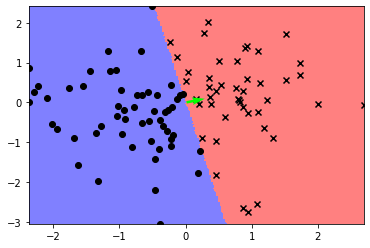

Training error: 0.0%


In [11]:
xTr,yTr=genrandomdata()
fun,w,b=primalSVM(xTr,yTr,C=10)
visclassifier(fun,xTr,yTr,w=w,b=b)


err=np.mean(arrayify(np.sign(fun(xTr)))!=yTr)
print("Training error: %2.1f%%" % (err*100))
# Training error should be ~4%

<h3>Example Test</h3> (use this as a starting point for making new tests!)

In [12]:
def testCase_Primal():
    Clocal = 1
    trainX = np.array([[0,0],[0,1],[0,2],[1,0],[1,1],[1,2],[2,0],[2,1],[2,2]]) 
    trainY = np.array([1,1,1,-1,1,1,-1,-1,1])
    fun_Primal,_,_ = primalSVM(trainX,trainY,C=Clocal)

    testX = np.array([[1.6,0.4],[1.4,1.6],[0.4,0.6],[0.4,1.6]])
    testY = np.array([-1,1,1,1])
    resultY = fun_Primal(testX)
    boolArray = (np.sign(resultY)==testY).tolist()
    signMatch = all(boolArray)
    return signMatch
print('primalSVM passes sign match test: ' + str(testCase_Primal()))

primalSVM passes sign match test: True


d:\programdata\anaconda3\envs\bidaf-pytorch-master\lib\site-packages\cvxpy\expressions\expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2 times so far.

  warnings.warn(msg, UserWarning)


In [13]:
# Hidden Test 1: testCase_Primal
# ------------------------------
# Given a fixed training set, this tests whether points farther from the decision boundary have larger predictions.

### Helper functions used to create animation

In [14]:
def updateboundary():
    global w,b,Xdata,ldata,stepsize

    _, w_pre, b_pre = primalSVM(np.transpose(Xdata),np.array(ldata),C=10)
    w = np.array(w_pre).reshape(-1)
    b = b_pre
    stepsize+=1

def updatescreen():
    global w,b,ax,line 
    q=-b/(w**2).sum()*w;
    if line==None:
        line, = ax.plot([q[0]-w[1],q[0]+w[1]],[q[1]+w[0],q[1]-w[0]],'b--')
    else:
        line.set_ydata([q[1]+w[0],q[1]-w[0]])
        line.set_xdata([q[0]-w[1],q[0]+w[1]])
    
def animate(i):
    #if len(ldata)>0 and ((min(ldata)+max(ldata))==0):
    if (len(ldata)>0) and ((np.min(ldata)+np.max(ldata))==0):
        if stepsize<1000:
            updateboundary()
            updatescreen();
    
def onclick(event):
    global Xdata, stepsize  
    if event.key == 'shift': # add positive point
        ax.plot(event.xdata,event.ydata,'or')
        label=1
    else: # add negative point
        ax.plot(event.xdata,event.ydata,'ob')
        label=-1    
    pos=np.array([[event.xdata],[event.ydata]])
    ldata.append(label);
    Xdata=np.hstack((Xdata,pos))
    stepsize=1;

    #if (len(ldata)>0) and ((np.min(ldata)+np.max(ldata))==0):
    #    if stepsize<1000:
    #        updateboundary()
    #        updatescreen()

### Animation

Text(0.5, 1.0, 'Use shift-click to add negative points.')

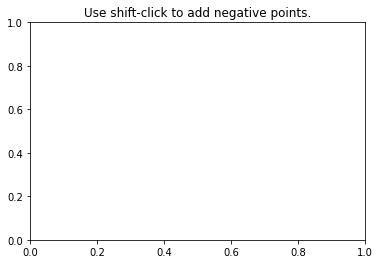

In [15]:
Xdata=np.random.rand(2,0)
ldata=[]
w=[]
b=[]
line=None
stepsize=1;
fig = plt.figure()
ax = fig.add_subplot(111)
plt.xlim(0,1)
plt.ylim(0,1)
cid = fig.canvas.mpl_connect('button_press_event', onclick)
ani = FuncAnimation(fig, animate,np.arange(1,100,1),interval=10);
plt.title('Use shift-click to add negative points.')
# Note that it is easy to generate odd decision boundaries, particularly if data is not easily linearly separable

<h3>Spiral data set</h3>

<p>The linear classifier works great in simple linear cases. But what if the data is more complicated? We provide you with a "spiral" data set. You can load it and visualize it with the following two code snippets:
<pre>

In [16]:
def spiraldata(N=300):
    r = np.linspace(1,2*np.pi,N)
    xTr1 = np.array([np.sin(2.*r)*r, np.cos(2*r)*r]).T
    xTr2 = np.array([np.sin(2.*r+np.pi)*r, np.cos(2*r+np.pi)*r]).T
    xTr = np.concatenate([xTr1, xTr2], axis=0)
    yTr = np.concatenate([np.ones(N), -1 * np.ones(N)])
    xTr = xTr + np.random.randn(xTr.shape[0], xTr.shape[1])*0.2
    
    xTe = xTr[::2,:]
    yTe = yTr[::2]
    xTr = xTr[1::2,:]
    yTr = yTr[1::2]
    
    return xTr,yTr,xTe,yTe

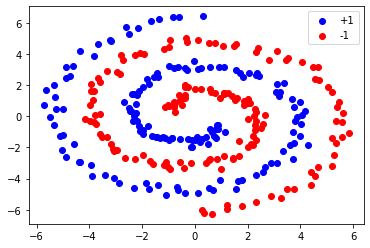

In [17]:
xTr,yTr,xTe,yTe=spiraldata()
fig = plt.figure()
plt.scatter(xTr[yTr == 1, 0], xTr[yTr == 1, 1], c='b')
plt.scatter(xTr[yTr != 1, 0], xTr[yTr != 1, 1], c='r')
plt.legend(["+1","-1"])
plt.show()

<p>If you apply your previously functioning linear classifier on this data set you will see that you get terrible results. Your training error will increase drastically. Further, if you increase $C$ the convex solver will even refuse to optimize as the initial solution is not even feasible! </p>

d:\programdata\anaconda3\envs\bidaf-pytorch-master\lib\site-packages\cvxpy\expressions\expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3 times so far.

  warnings.warn(msg, UserWarning)


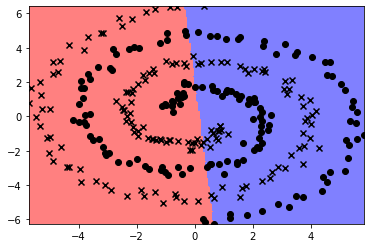

Training error: 41.0%


In [18]:
fun,w,b=primalSVM(xTr,yTr,C=0.01)
visclassifier(fun,xTr,yTr,w=[],b=0)
err=np.mean(arrayify(np.sign(fun(xTr)))!=yTr)
print("Training error: %2.1f%%" % (err*100))

<h3>Implementing a kernelized SVM</h3>

<p> For a data set as complex as the spiral data set, you will need a more complex classifier. 
First implement the kernel function
<pre>	computeK(kerneltype,X,Z,kpar)</pre>
It takes as input a kernel type (kerneltype) and two data sets $\mathbf{X}$ in $\mathcal{R}^{n\times d}$ and $\mathbf{Z}$ in $\mathcal{R}^{m\times d}$ and outputs a kernel matrix $\mathbf{K}\in{\mathcal{R}^{n\times m}}$. The last input, <code>kpar</code> specifies the kernel parameter (e.g. the inverse kernel width $\gamma$ in the RBF case or the degree $p$ in the polynomial case.)
	<ol>
	<li>For the linear kernel (<code>ktype='linear'</code>) svm, use $k(\mathbf{x},\mathbf{z})=x^Tz$ </li> 
	<li>For the radial basis function kernel (<code>ktype='rbf'</code>) svm use $k(\mathbf{x},\mathbf{z})=\exp(-\gamma ||x-z||^2)$ (gamma is a hyperparameter, passed a the value of kpar)</li>
	<li>For the polynomial kernel (<code>ktype='poly'</code>) use  $k(\mathbf{x},\mathbf{z})=(x^Tz + 1)^d$ (d is the degree of the polymial, passed as the value of kpar)</li>
</ol>

<p>You can use the function <b><code>cdist</code></b> as a helperfunction.</p>





In [25]:
def computeK(kerneltype, X, Z, kpar=0):
    """
    function K = computeK(kernel_type, X, Z)
    computes a matrix K such that Kij=k(x,z);
    for three different function linear, rbf or polynomial.
    
    Input:
    kerneltype: either 'linear','polynomial','rbf'
    X: n input vectors of dimension d (nxd);
    Z: m input vectors of dimension d (mxd);
    kpar: kernel parameter (inverse kernel width gamma in case of RBF, degree in case of polynomial)
    
    OUTPUT:
    K : nxm kernel matrix
    """
    assert kerneltype in ["linear","polynomial","poly","rbf"], "Kernel type %s not known." % kerneltype
    assert X.shape[1] == Z.shape[1], "Input dimensions do not match"
    
    # YOUR CODE HERE
    if kerneltype == "linear":
        K=np.dot(X, Z.T)
    if kerneltype == "polynomial" or kerneltype == "poly":
        K = np.power(np.dot(X, Z.T) + 1.0, kpar)
    if kerneltype == "rbf":
        K = np.exp(- kpar * np.power(cdist(X, Z), 2))
    
    
    return K

<h3>Example Test</h3> (use this as a starting point for making new tests!)

In [26]:
def isClose(num1,num2,numtol=1e-3):
    return np.abs(num1-num2)<numtol

def isMatClose(X1,X2,tol=1e-3):
    a,b = X1.shape
    output = True
    for i in range(a):
        for j in range(b):
            output = output and isClose(X1[i][j],X2[i][j],numtol=tol)
    return output 

def testCase_computeK_linear():
    X = np.array([[9],[0]])
    Z = np.array([[1],[3]])
    K = computeK('linear',X,Z)
    K = np.array(K)
    check = isMatClose(K,np.array([[9,27],[0,0]])) 
    return check

print('computeK passes test for linear kernel: ' + str(testCase_computeK_linear()))

computeK passes test for linear kernel: True


In [27]:
# Hidden Test 2: testCase_computeK_linear
# ---------------------------------------
# This tests whether the linear kernel is computed properly on an example dataset.

In [28]:
# Hidden Test 3: testCase_computeK_polynomial
# -------------------------------------------
# This tests whether the polynomial kernel is computed properly on an example dataset.

In [29]:
# Hidden Test 4: testCase_computeK_rbf
# ------------------------------------
# This tests whether the rbf kernel is computed properly on an example dataset.

<h3>Additional Testing</h3>
<p>The following code snippet plots an image of the kernel matrix for the data points in the spiral set. Use it to test your <b><code>computeK</code></b> function:</p>

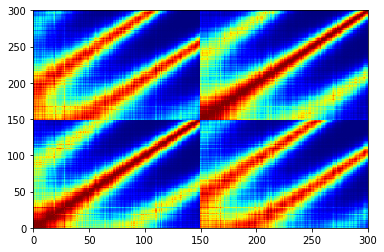

In [30]:
xTr,yTr,xTe,yTe=spiraldata()
K=computeK("rbf",xTr,xTr,kpar=0.05)
# plot an image of the kernel matrix
fig = plt.figure()
plt.pcolormesh(K, cmap='jet')
plt.show()

Remember that the SVM optimization has the following dual formulation:
$$
\begin{aligned}
             &\min_{\alpha_1,\cdots,\alpha_n}\frac{1}{2} \sum_{i,j}\alpha_i \alpha_j y_i y_j \mathbf{K}_{ij} - \sum_{i=1}^{n}\alpha_i  \\
       \text{s.t.}  &\quad 0 \leq \alpha_i \leq C\\
             &\quad \sum_{i=1}^{n} \alpha_i y_i = 0.
\end{aligned}
$$
This is equivalent to solving for the SVM primal
$$ L(\mathbf{w},b) = C\sum_{i=1}^n \max(1-y_i(\mathbf{w}^\top\phi(\mathbf{x}_i)+b),0) + ||w||_2^2$$
where $\mathbf{w}=\sum_{i=1}^n y_i \alpha_i \phi(\mathbf{x}_i)$ and $\mathbf{K}_{ij}=k(\mathbf{x}_i,\mathbf{x}_j)=\phi(\mathbf{x}_i)^\top\phi(\mathbf{x}_j)$, for some mapping $\phi(\cdot)$.  Please note that here all $\alpha_i\geq 0$, which is possible because we multiply by $y_i$ in the definition of $\mathbf{w}$. One advantage of keeping all $\alpha_i$ non-negative is that we can easily identify non-support vectors as vectors with $\alpha_i=0$. 

<p>Implement the function <code>dualqp</code>, which takes as input a kernel matrix $K$, a vector of labels $yTr$ in $\mathcal{R}^{n}$, and a regularization constant $C\geq 0$. This function should solve the quadratic optimization problem and output the optimal vector $\mathbf{\alpha}\in{\mathcal{R}^n}$.</p>



In [33]:
def dualqp(K,yTr,C):
    """
    function alpha = dualqp(K,yTr,C)
    constructs the SVM dual formulation and uses a built-in 
    convex solver to find the optimal solution. 
    
    Input:
        K     | the (nxn) kernel matrix
        yTr   | training labels (nx1)
        C     | the SVM regularization parameter
    
    Output:
        alpha | the calculated solution vector (nx1)
    """
    y = yTr.flatten()
    N, _ = K.shape
    alpha = Variable(N)
    
    # YOUR CODE HERE
    ay = multiply(y, alpha)
    objective = - sum(alpha) + 0.5 * quad_form(ay, K)
    constraints = [alpha >= 0, alpha <= C, sum(ay) == 0]
    prob = Problem(Minimize(objective), constraints)
    prob.solve()
    
    return np.array(alpha.value).flatten()

The following code shows a usecase of how <code>dualqp</code> could be used in practice. 

In [34]:
C = 10
lmbda = 0.25
ktype = "rbf"
xTr,yTr,xTe,yTe=spiraldata()
# compute kernel (make sure it is PSD)
K = computeK(ktype,xTr,xTr)
eps = 1e-8
# make sure it is symmetric and positive semi-definite
K = (K + K.T) / 2 + eps * np.eye(K.shape[0])

alpha=dualqp(K,yTr,C)

<h3>Testing Hint</h3> Create a dataset where you know what some of the optimal values of $\alpha$ will be, and test to make sure that the solution gets those values of $\alpha$ correct (recall from the lecture that the $\alpha$ values associated with certain data points are guaranteed to have a specific optimal value).

In [35]:
# Hidden Test 5: testCase_dualQP
# ------------------------------
# This tests whether the alphas computed from dual qp are close to the correct values for an example dataset.

<p> Now that you can solve the dual correctly, you should have the values for $\alpha_i$. But you are not done yet. You still need to be able to classify new test points. Remember from class that $h(\mathbf{x})=\sum_{i=1}^n \alpha_i y_i k(\mathbf{x}_i,\mathbf{x})+b$. You need to obtain $b$. It is easy to show (and omitted here) that if $C>\alpha_i>0$ (with strict $>$), then we must have that $y_i(\mathbf{w}^\top \phi(\mathbf{x}_i)+b)=1$. Rephrase this equality in terms of $\alpha_i$ and solve for $b$. Implement

<p> b=recoverBias(K,yTr,alphas,C); </p>

<p> where <code>b</code> is the hyperplane bias.
(Hint: This is most stable if you pick an $\alpha_i$ that is furthest from $C$ and $0$. )</p>

<p>Please note that this use of the word bias has absolutely nothing to do with the word bias in the bias variance trade-off. It is just the same word but two completely different meanings. This unfortunate term collision comes from the fact that we are borrowing concepts from geometry and statistics.</p>

In [36]:
def recoverBias(K,yTr,alpha,C):
    """
    function bias=recoverBias(K,yTr,alpha,C);
    Solves for the hyperplane bias term, which is uniquely specified by the 
    support vectors with alpha values 0<alpha<C
    
    INPUT:
    K : nxn kernel matrix
    yTr : nx1 input labels
    alpha  : nx1 vector of alpha values
    C : regularization constant
    
    Output:
    bias : the scalar hyperplane bias of the kernel SVM specified by alphas
    """

    # YOUR CODE HERE
    alpha = np.array(alpha)
    y_idx = np.argmin(np.abs(alpha - C*0.5))
    bias = (1.0 / yTr[y_idx]) - np.multiply(yTr, alpha).dot(K[y_idx, :])
    
    return bias

<h3>Testing</h3>
<p> Test your <b><code>recoverBias</code></b> function with the following code, which uses the dual solver on a linearly separable dataset:</p>

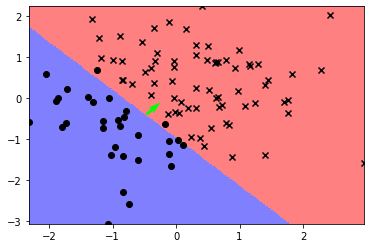

In [37]:
xTr,yTr=genrandomdata(b=0.5)
C=1
K=computeK("linear",xTr,xTr)
eps=1e-8
K = (K + K.T) / 2 + eps * np.eye(K.shape[0])
alpha = dualqp(K,yTr,C)
ba=recoverBias(K,yTr,alpha,C)
wa = (alpha * yTr).dot(xTr)
fun = lambda x: x.dot(wa) + ba
visclassifier(fun, xTr, yTr, w=wa, b=ba)
# Note: In some cases you may get an error or an odd plot. This is because sometimes 
#       the randomly generated data makes the kernel matrix close to singular. For 
#       graded hidden tests the randomness is fixed so this will not be an issue.

In [38]:
# Hidden Test 6: testCase_recoverBias
# -----------------------------------
# This tests whether the bias computed from recoverBias is close to the correct value for an example dataset.

<p>
    Implement the function 
    <pre>
    svmclassify=dualSVM(xTr,yTr,C,ktype,kpar);
    </pre>
    It should use your functions <code><b>computeK</b></code> and <code><b>generateQP</b></code> to solve the SVM dual problem of an SVM specified by a training data set (<code><b>xTr,yTr</b></code>), a regularization parameter (<code>C</code>), a kernel type (<code>ktype</code>) and kernel parameter (<code>lmbda</code>, to be used as kpar in Kernel construction). Then, find the support vectors and recover the bias to return <b><code>svmclassify</code></b>, a function that uses your SVM to classify a set of test points <code>xTe</code>.

<b>Hint: You need to ensure that the kernel matrix is positive semi-definite during training. The best way to do this is to make sure it is strictly symmetric and to add the identity matrix to it, multiplied by a tiny epsilon value.</b>
    
</p>


In [39]:
def dualSVM(xTr,yTr,C,ktype,lmbda,eps=1e-8):
    """
    function classifier = dualSVM(xTr,yTr,C,ktype,lmbda);
    Constructs the SVM dual formulation and uses a built-in 
    convex solver to find the optimal solution. 
    
    Input:
        xTr   | training data (nxd)
        yTr   | training labels (nx1)
        C     | the SVM regularization parameter
        ktype | the type of kernelization: 'rbf','polynomial','linear'
        lmbda | the kernel parameter - degree for poly, inverse width for rbf
    
    Output:
        svmclassify | usage: predictions=svmclassify(xTe);
    """
    svmclassify = lambda x: x # CHANGE THIS
    
    # YOUR CODE HERE
    K = computeK(ktype, xTr, xTr, lmbda)
    alpha = dualqp(K,yTr,C)
    bias = recoverBias(K,yTr,alpha,C)
    
    svmclassify = lambda x: np.dot(np.multiply(alpha,yTr), computeK(ktype, xTr, x, lmbda)) + bias

    
    return svmclassify

<h3>Testing</h3>
<p>Now we try the SVM with RBF kernel on the spiral data. <b>If you implemented it correctly, train and test error should be close to zero.</b></p>

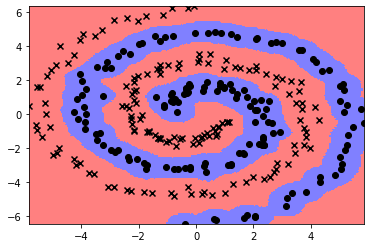

Training error: 0.0000
Testing error: 0.0000


In [40]:
xTr,yTr,xTe,yTe=spiraldata()
C=10.0
sigma=10.0 # Note: If sigma is too small you may get convergence errors.
ktype="rbf"
svmclassify=dualSVM(xTr,yTr,C,ktype,sigma)

visclassifier(svmclassify,xTr,yTr)

# compute training and testing error
predsTr=svmclassify(xTr)
trainingerr=np.mean(np.sign(predsTr)!=yTr)
print("Training error: %2.4f" % trainingerr)

predsTe=svmclassify(xTe)
testingerr=np.mean(np.sign(predsTe)!=yTe)
print("Testing error: %2.4f" % testingerr)

In [41]:
# Hidden Test 7: testCase_dualSVM_easy_dataset
# --------------------------------------------
# This tests whether the function from dualSVM correctly classifies an example dataset.

In [42]:
# Hidden Test 8: testCase_dualSVM_hard_dataset
# --------------------------------------------
# This tests whether the function from dualSVM correctly classifies a hard example dataset.

In [43]:
# Hidden Test 9: testCase_dualSVM_hard_dataset2
# ---------------------------------------------
# This tests whether the function from dualSVM correctly classifies an even harder example dataset.

SVMs are pretty sensitive to hyper-parameters. We can visualize the results of a hyper-parameter grid search as a heat-map, where we sweep across different values of C and kpar and output the result on a validation dataset. Now we ask you to implement a cross-validation function.

In [44]:
def cross_validation(xTr,yTr,xValid,yValid,ktype,CList,lmbdaList):
    """
    function bestC,bestLmbda,ErrorMatrix = cross_validation(xTr,yTr,xValid,yValid,ktype,CList,lmbdaList);
    Use the parameter search to find the optimal parameter,
    Individual models are trained on (xTr,yTr) while validated on (xValid,yValid)
    
    Input:
        xTr      | training data (nxd)
        yTr      | training labels (nx1)
        xValid   | training data (mxd)
        yValid   | training labels (mx1)
        ktype    | the type of kernelization: 'rbf','polynomial','linear'
        CList    | The list of values to try for the SVM regularization parameter C (ax1)
        lmbdaList| The list of values to try for the kernel parameter lmbda- degree for poly, inverse width for rbf (bx1)
    
    Output:
        bestC      | the best C parameter
        bestLmbda  | the best Lmbda parameter
        ErrorMatrix| the test error rate for each given C and Lmbda when trained on (xTr,yTr) and tested on (xValid,yValid),(axb)
    """
    # gridsearch for best parameters
    ErrorMatrix=np.zeros((len(CList),len(lmbdaList)))
    bestC,bestLmbda = 0.,0.
    
    # YOUR CODE HERE
    minimum_error = 1.0 #the minimum error
    for i in range(len(CList)):
        C = CList[i]
        for j in range(len(lmbdaList)):
            # import pdb;pdb.set_trace()
            lmbda = lmbdaList[j]
            svmclassify = dualSVM(xTr,yTr,C,ktype,lmbda)
            yPred = svmclassify(xValid)
            error = np.mean(np.sign(yPred) != yValid)
            ErrorMatrix[i, j] = error
            if error < minimum_error:
                minimum_error = error
                bestC = C
                bestLmbda = lmbda
            
    return bestC,bestLmbda,ErrorMatrix

<h3>Testing</h3>

Text(0.5, 1.0, 'Validation error')

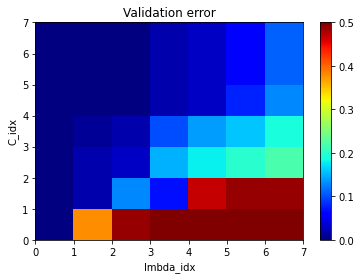

In [45]:
np.random.seed(15)
xTr,yTr,xValid,yValid=spiraldata(100)
CList=(2.0**np.linspace(-2,1,7))
lmbdaList=(np.linspace(1.0,15,7))

bestC,bestLmbda,ErrorMatrix = cross_validation(xTr,yTr,xValid,yValid,'rbf',CList,lmbdaList)
fig = plt.figure()
plt.pcolormesh(ErrorMatrix, cmap='jet')
plt.colorbar()
plt.xlabel("lmbda_idx")
plt.ylabel("C_idx")
plt.title("Validation error")

If you implemented everything correctly, the result should look similar to this image:
<center>
 <img src="crossval.png" width="300px" />
</center>

In [46]:
# Hidden Test 10: testCase_cv
# ---------------------------
# This tests whether the error matrix from cross_validation is correct for an example dataset.

<h3>Competition</h3>

We ask you to implement the function autosvm(), which given xTr and yTr, splits them into training data and validation data, and then uses a hyperparameter search to find the optimal hyper parameters. 

Function autosvm should return a function which will act as a classifier on xTe.

The competition will test multiple datasets, each dataset having different optimal hyperparameters, so you should strive for a good method of finding hyperparameters (within the time limit) instead of just trying to find a static set of good hyperparameters. 

You will get <b>5 points</b> for the competition if you can beat the base benchmark of <b>43%</b> error, and an additional <b>5 points</b> if you can get an error rate below <b>34%</b>.

In [49]:
def autosvm(xTr,yTr):
    """
    svmclassify = autosvm(xTr,yTr), where yTe = svmclassify(xTe)
    """
    n,_ = xTr.shape
    xTr2=xTr
    split=[2.0,1.5,3.3,5.0,10.0]
    #nn=np.ceil(n/50.0)
    CList=(2.0**np.linspace(-2,5,8))
    lmbdaList=(np.linspace(0.01,0.4,6))
    bestC=np.zeros(len(split))
    bestLmbda=np.zeros(len(split))
    val=1
    nxTr=np.copy(xTr)
    nyTr=np.copy(yTr)
    # lets run it for 5 different versions of valodation data
    for i in range(0,len(split)):
        #np.random.shuffle(xTr2)
    
        nn=np.ceil(n/split[i])
#         print("nn")
#         print(nn)
        xV, xT =nxTr[:nn,:], nxTr[nn:,:]
        #print(xV.shape)
        #print(xT.shape)
        #print(xT[0])
        yV,yT=nyTr[:nn], nyTr[nn:]

        C,lmbda,Errmat= cross_validation(xT,yT,xV,yV,'rbf',CList,lmbdaList)
        svmclassify1=dualSVM(xT,yT,C,"rbf",lmbda)
        predsTe=svmclassify1(xV)
        testingerr=np.mean(np.sign(predsTe)!=yV)
#         print(testingerr)
        if(testingerr<val):
            bestC[0]=C
            bestLmbda[0] = lmbda
            val=testingerr
#         print("bestC")
#         print(bestC[0])
#         print("Lambda")
#         print(bestLmbda[0])
        #p = np.random.permutation(n)
        #nxTr=np.copy(xTr[p])
        #nyTr=np.copy(yTr[p])
#     print("Final C and lmbda")
    FinalC=bestC[0]
    Finallmbda=bestLmbda[0]
#     print(FinalC,Finallmbda)
    #print(np.mean(bestC),np.mean(bestLmbda))

    svmclassify=dualSVM(xT,yT,FinalC,"rbf",Finallmbda)
    return svmclassify

In [ ]:
# Hidden Test 11: competition
# ---------------------------
# This tests the error rate of your classifier on the competition datasets 
# (remember each cell in this notebook should run in < 5 minutes!)

In [ ]:
# Prints out the summary of tests passed/failed.